## Init

In [10]:
repo = "https://github.com/ventus550/HandwritingRecognition"
gdrv = "MyDrive/MachineLearningProjects/HandwritingRecognition"
! ! (git status 2> /dev/null) && git clone {repo}
%cd HandwritingRecognition/notebooks

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
[Errno 2] No such file or directory: 'HandwritingRecognition/notebooks'
/content/HandwritingRecognition/notebooks


In [11]:
import os, sys
sys.path.append("..")

In [27]:
data_path = "data"
models_path = "models"
try:
    from google.colab import drive
    drive.mount('../data', force_remount=True)
    data_path = f"{data_path}/{gdrv}"
    models_path = f"{data_path}/{models_path}"
except ModuleNotFoundError: ...


Mounted at ../data


In [13]:
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pathlib import Path
import utils

## Configuration

In [28]:
BASEDIR = Path(os.getcwd()).parent
DESTDIR = BASEDIR / data_path / "etl_output"
MODLDIR = BASEDIR / models_path
DATASET = DESTDIR / "words.dts"
model_name  = "new.h5"

In [15]:
image_width = 128
image_height = 32
epochs = 1  # Should be at least 50

max_len = 21
padding_token = 99
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
characters = [
	'!', '"', '#', '&', "'", '(', ')', '*', '+', ',',
	'-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
	'7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D',
	'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
	'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
	'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
	'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
	's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


## Load data

In [16]:
def split_dataset(ds: tf.data.Dataset, left_frac = 0.5):
    N = len(ds)
    L = int(left_frac * N)
    ds = ds.shuffle(N)
    return ds.take(L), ds.skip(L).take(N - L)

dataset = tf.data.Dataset.load(str(DATASET))
train_ds, dataset = split_dataset(dataset, 0.9)
validation_ds, test_ds = split_dataset(dataset, 0.5)

In [17]:
len(train_ds), len(validation_ds), len(test_ds)

(1181, 66, 66)

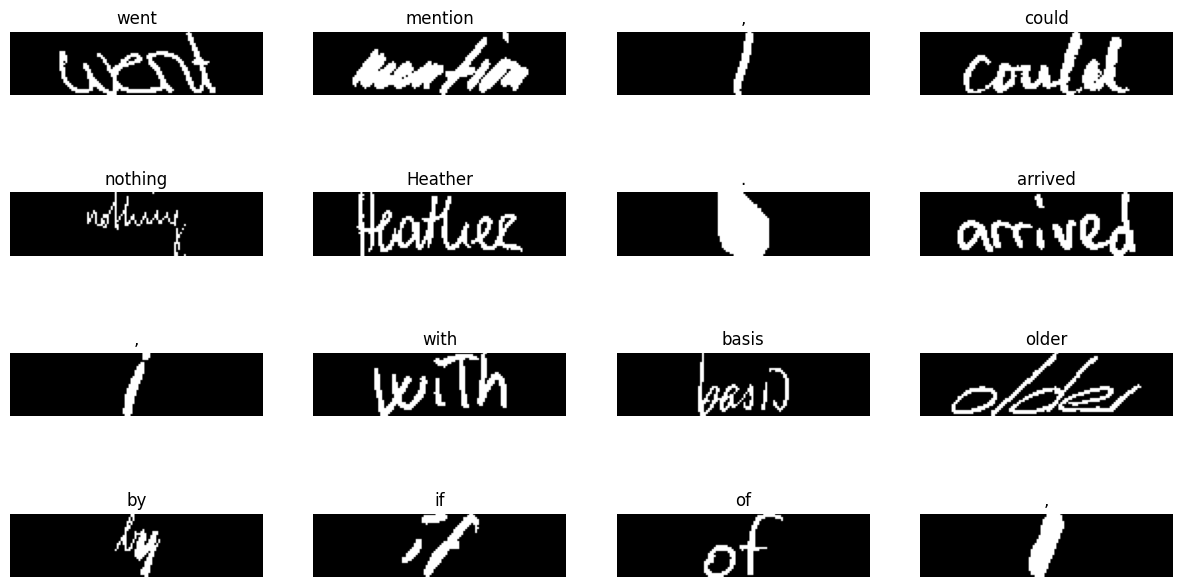

In [18]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [19]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [20]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for data in validation_ds:
            labels, images = data["label"], data["image"]
            predictions = self.prediction_model.predict(images)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [21]:

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


2/2 [==============================] - 0s 6ms/step
Mean edit distance for epoch 1: 20.3698
1181/1181 [==============================] - 70s 43ms/step - loss: 13.2072 - val_loss: 10.5321


In [29]:
Path(MODLDIR).mkdir(parents=True, exist_ok=True)
utils.save(prediction_model, MODLDIR / model_name, {"epochs": epochs})

2/2 [==============================] - 0s 7ms/step


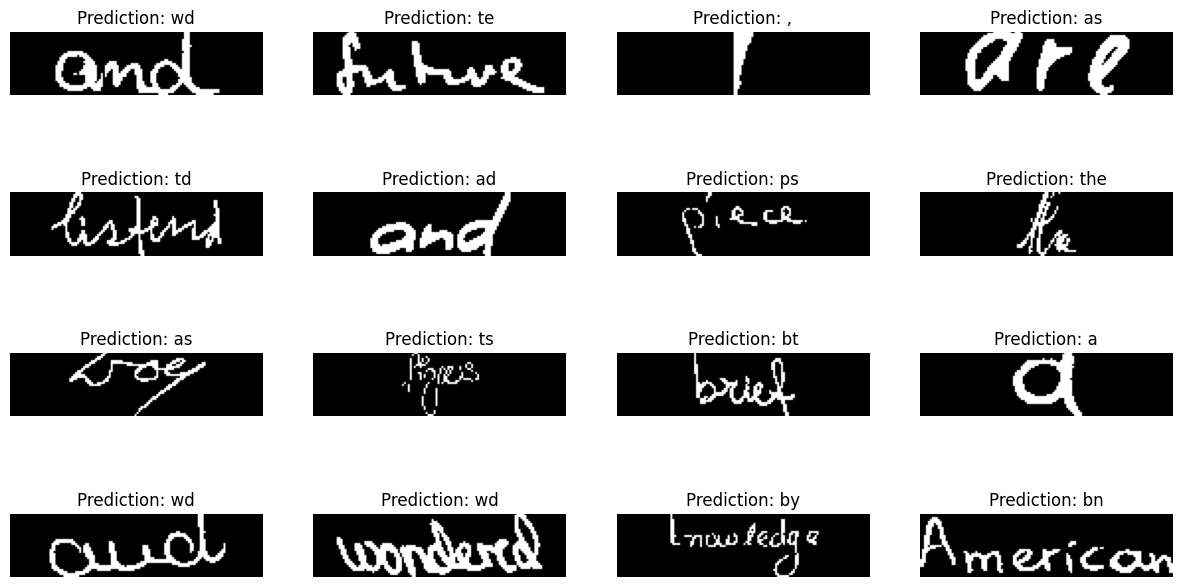

In [23]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()